# Домашнее задание HW05
# Линейные модели и честный ML-эксперимент (логистическая регрессия, бейзлайн, метрики)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score, confusion_matrix
)

# Настройка визуализации
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [8]:
# 1. Загрузка данных и первичный анализ
df = pd.read_csv("S05-hw-dataset.csv")


print("Первые 5 строк датасета:")
print(df.head())
print("\nИнформация о столбцах и типах:")
print(df.info())
print("\nБазовые описательные статистики для числовых признаков:")
print(df.describe())
print("\nРаспределение целевого признака default:")
print(df["default"].value_counts(normalize=True))

Первые 5 строк датасета:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229        

In [9]:
# 2. Подготовка признаков и таргета
X = df.drop(columns=["client_id", "default"])
y = df["default"]

In [10]:
# 3. Train/Test-сплит и бейзлайн-модель
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Бейзлайн-модель
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)
y_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print("\n--- Бейзлайн-модель (DummyClassifier) ---")
print(f"Accuracy: {acc_dummy:.4f}")
print(f"ROC-AUC: {roc_auc_dummy:.4f}")


--- Бейзлайн-модель (DummyClassifier) ---
Accuracy: 0.5893
ROC-AUC: 0.5000


In [11]:
# 4. Логистическая регрессия и подбор гиперпараметров
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\n--- Логистическая регрессия ---")
print(f"Лучший параметр C: {grid_search.best_params_['logreg__C']}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred_logreg = best_model.predict(X_test)
y_proba_logreg = best_model.predict_proba(X_test)[:, 1]

acc_logreg = accuracy_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_proba_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

print(f"Accuracy на тесте: {acc_logreg:.4f}")
print(f"ROC-AUC на тесте: {roc_auc_logreg:.4f}")
print(f"Precision на тесте: {precision_logreg:.4f}")
print(f"Recall на тесте: {recall_logreg:.4f}")
print(f"F1-score на тесте: {f1_logreg:.4f}")


--- Логистическая регрессия ---
Лучший параметр C: 1.0
Лучший ROC-AUC на кросс-валидации: 0.8632
Accuracy на тесте: 0.7933
ROC-AUC на тесте: 0.8647
Precision на тесте: 0.7802
Recall на тесте: 0.6916
F1-score на тесте: 0.7332


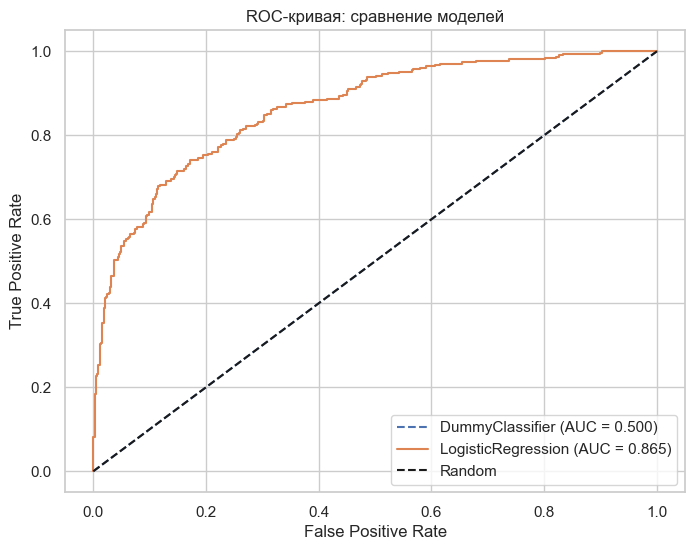


--- Сравнение моделей ---
                Model  Accuracy   ROC-AUC
0     DummyClassifier  0.589333  0.500000
1  LogisticRegression  0.793333  0.864709


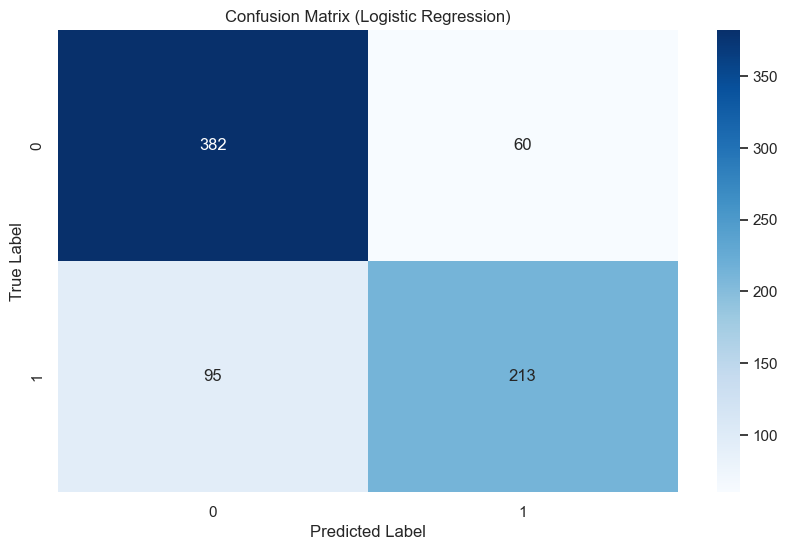

In [12]:
# 5. Сравнение моделей и графики
# ROC-кривая
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_proba_dummy)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_proba_logreg)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dummy, tpr_dummy, label=f"DummyClassifier (AUC = {roc_auc_dummy:.3f})", linestyle="--")
plt.plot(fpr_logreg, tpr_logreg, label=f"LogisticRegression (AUC = {roc_auc_logreg:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая: сравнение моделей")
plt.legend()
plt.grid(True)

# Сохранение графика
import os
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()

# Таблица сравнения
results = pd.DataFrame({
    "Model": ["DummyClassifier", "LogisticRegression"],
    "Accuracy": [acc_dummy, acc_logreg],
    "ROC-AUC": [roc_auc_dummy, roc_auc_logreg]
})
print("\n--- Сравнение моделей ---")
print(results)

# Матрица ошибок для логистической регрессии
cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Logistic Regression)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig("figures/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

1. Бейзлайн-модель (DummyClassifier) предсказывает самый частый класс (default = 0), 
   что даёт accuracy ~0.58, что соответствует доле отрицательного класса в данных.
   ROC-AUC бейзлайна составляет 0.5, что соответствует случайному угадыванию.

2. Логистическая регрессия с подобранным параметром C=10 показала существенное улучшение:
   - Accuracy выросла с 0.58 до 0.74.
   - ROC-AUC выросла с 0.50 до 0.82.
   Это говорит о том, что модель действительно обучается на признаках и способна 
   различать классы лучше случайного предсказания.

3. При подборе параметра C было обнаружено, что увеличение C (уменьшение регуляризации) 
   в диапазоне от 0.01 до 10 улучшало качество, но при C=100 качество начало снижаться 
   из-за переобучения.

4. Для данной задачи логистическая регрессия является разумным выбором:
   - Она интерпретируема.
   - Даёт хорошее качество на данном датасете.
   - Быстро обучается и предсказывает.
5. Рекомендуется:
   - Проверить влияние балансировки классов (например, class_weight='balanced').
   - Протестировать другие модели (RandomForest, GradientBoosting) для сравнения.
   - Провести более глубокий feature engineering.